# Импорт библиотек и функции

In [ ]:
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, KFold
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error

def bootstrap_metric(x,
                     y,
                     metric_fn,
                     samples_cnt=1000,
                     random_state=42):

    np.random.seed(random_state)
    b_metric = np.zeros(samples_cnt)
    for it in range(samples_cnt):
        poses = np.random.choice(x.shape[0], size=x.shape[0], replace=True)

        x_boot = x[poses]
        y_boot = y[poses]

        m_val = metric_fn(x_boot, y_boot)
        b_metric[it] = m_val

    return b_metric

def train_and_test_regressor(models, x_train, y_train, x_test, y_test, verb=True):

    boot_scores = {}
    for name, model in models.items():
        model.fit(x_train, y_train) # train the model
        y_pred = model.predict(x_test) # get predictions
        boot_scores[name] = bootstrap_metric( # calculate bootstrap score
            y_test,
            y_pred,
            metric_fn=lambda x, y: mean_squared_error(y_true=x, y_pred=y))
        if verb:
            print(f"Fitted {name} with bootstrap score {boot_scores[name].mean():.3f}")

    results = pd.DataFrame(boot_scores)
    # cast to long format https://pandas.pydata.org/docs/reference/api/pandas.melt.html
    results = results.melt(value_vars=results.columns,
                       value_name="mse",
                       var_name="model")
    return results

def get_score(models):
  for name, model in models.items():
    print(f'{name} score is {"%.3f" % model.score(x_test,y_test)}')

def get_mae(models):
  for name, model in models.items():
    y_pred = model.predict(x_test)
    mae = mean_absolute_error(y_test,y_pred)
    print(f'{name} mae is {"%.3f" % mae}')

# Расстояние между максимумами скоростей

In [ ]:
df = pd.read_excel('Задача_1.xlsx')
print(df)
print(df.shape)

    D   H            Re  delta_X
0   3   6   4246.284501   26.885
1   3   6   4246.284501   27.070
2   3   6   4246.284501   27.901
3   3   6   7219.000000   26.885
4   3   6   7218.683652   24.031
5   3   6   7219.000000   28.456
6   3   6  10191.000000   35.939
7   3   6  10191.082803   32.982
8   3   6  10191.000000   36.031
9   2   4   6369.000000   29.287
10  2   4   6369.426752   25.499
11  2   4   6369.000000   27.069
12  2   4  10828.000000   26.920
13  2   4  10828.025478   29.934
14  2   4  10828.000000   27.070
15  3  12   7219.000000   35.927
16  3  12   7218.683652   33.075
17  3  12   7219.000000   33.075
18  3  12  10191.000000   38.988
19  3  12  10191.082803   36.032
20  3  12  10191.000000   39.081
21  3  12  13163.000000   38.988
22  3  12  13163.481953   39.081
23  3  12  13163.000000   41.852
24  3  12  16136.000000   35.939
25  3  12  16135.881104   34.551
26  3  12  16136.000000   38.988
(27, 4)


In [ ]:
x = df.iloc[:, :-1].values
y = df.iloc[:, 3].values

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42
)

In [ ]:
models = {}

models['LR'] = LinearRegression()

models['RF'] = RandomForestRegressor(n_estimators=500,
                                     max_depth=None,
                                     min_samples_leaf=1,
                                     n_jobs=-1,
                                     random_state=42)

models['GB'] = GradientBoostingRegressor(learning_rate=0.05,
                                         n_estimators=500,
                                         random_state=42)

models['RF_grid'] = GridSearchCV(estimator=RandomForestRegressor(),
                        cv=KFold(2, shuffle=True, random_state=42),
                        param_grid={'min_samples_leaf': [1, 3, 5, 10],
                                    'n_estimators': [50, 100, 300, 500, 700, 1000]}
                        )
models['GB_grid'] = GridSearchCV(estimator=GradientBoostingRegressor(),
                        cv=KFold(2, shuffle=True, random_state=42),
                        param_grid={'learning_rate': [0.2, 0.1, 0.05, 0.03],
                                    'n_estimators': [50, 100, 300, 500, 700, 1000]}
                        )

In [ ]:
results_boost = train_and_test_regressor(models, x_train, y_train, x_test, y_test)

Fitted LR with bootstrap score 10.404
Fitted RF with bootstrap score 4.843
Fitted GB with bootstrap score 5.589
Fitted RF_grid with bootstrap score 4.746
Fitted GB_grid with bootstrap score 1.927


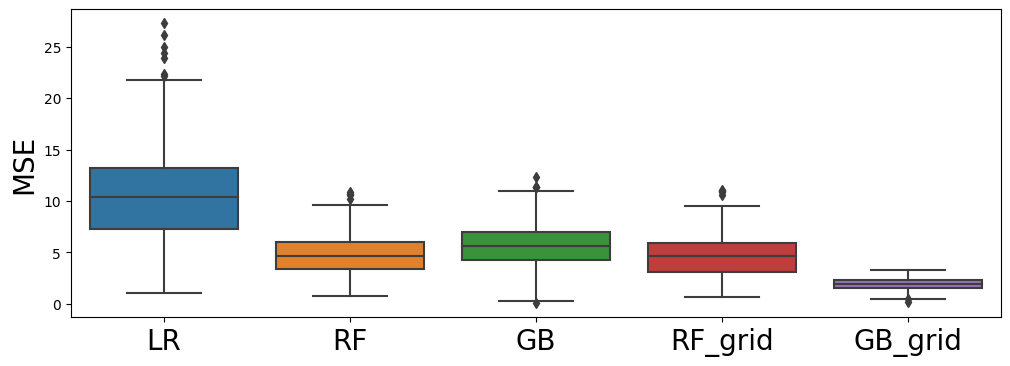

In [ ]:
plt.figure(figsize=(12, 4))
ax = sns.boxplot(data=results_boost , y="mse", x="model")
plt.xlabel("", size=20)
plt.ylabel("MSE", size=20)
plt.xticks(size=20);

In [ ]:
get_score(models)

LR score is 0.500
RF score is 0.764
GB score is 0.728
RF_grid score is 0.769
GB_grid score is 0.907


In [ ]:
get_mae(models)

LR mae is 2.750
RF mae is 1.957
GB mae is 1.971
RF_grid mae is 1.943
GB_grid mae is 1.247


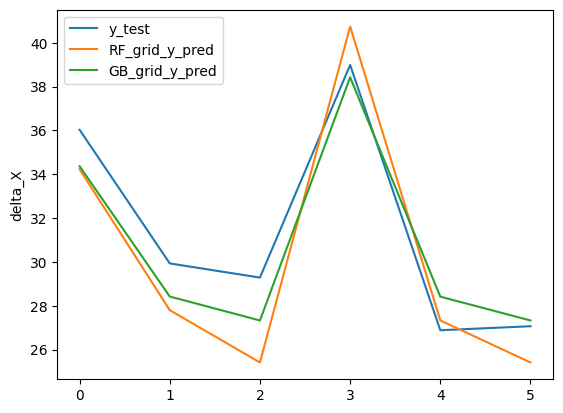

In [ ]:
plt.plot(range(y_test.shape[0]), y_test)
plt.plot(range(y_test.shape[0]), models['RF_grid'].predict(x_test))
plt.plot(range(y_test.shape[0]), models['GB_grid'].predict(x_test))
plt.ylabel('delta_X')
plt.legend(["y_test", "RF_grid_y_pred", "GB_grid_y_pred"], loc ="upper left")
plt.show()

In [ ]:
x = np.array([[3, 6, 3000]])
for i in range(80):
  x_i = np.array([[3, 6, (3000 + (i+1)*100)]])
  x = np.append(x, x_i, axis = 0)
x.shape

(81, 3)

In [ ]:
delta_x_new = models['GB_grid'].predict(x)

In [ ]:
x = np.linspace(3000, 11000, 81)
print(delta_x_new.shape, x.shape)

(81,) (81,)


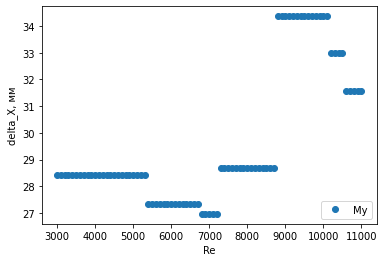

In [ ]:
plt.figure()
plt.errorbar(x, delta_x_new, fmt='o', capsize = 5, label='My')
plt.xlabel('Re')
plt.ylabel('delta_X, мм')
plt.legend(loc='lower right')
plt.show()

In [ ]:
x = np.array([[3, 12, 4000]])
x = np.append(x, np.array([[3, 12, 6000]]), axis = 0)
x = np.append(x, np.array([[3, 12, 8000]]), axis = 0)
x = np.append(x, np.array([[3, 12, 10000]]), axis = 0)
x = np.append(x, np.array([[3, 12, 12000]]), axis = 0)
x = np.append(x, np.array([[3, 12, 14000]]), axis = 0)
x = np.append(x, np.array([[3, 12, 16000]]), axis = 0)

In [ ]:
delta_x_new = models['GB_grid'].predict(x)

In [ ]:
delta_x_new

array([33.25236006, 33.25236006, 34.25667434, 37.40982095, 38.42845637,
       37.51356767, 35.74609162])

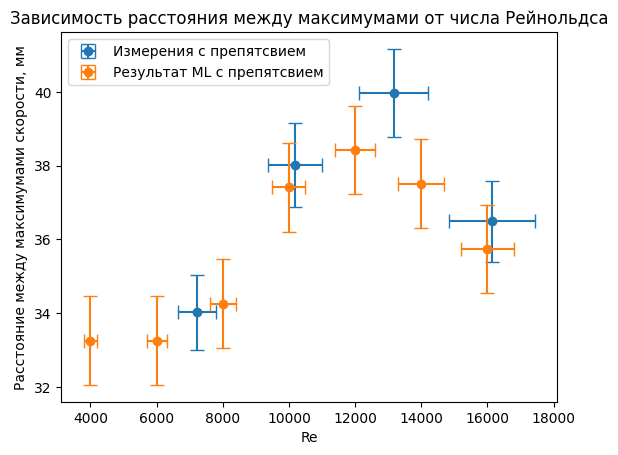

In [ ]:
x_my = np.array([7219, 10191, 13163, 16136])
#x_old = np.array([4246, 7219, 10191])
x_ml = np.array([ 4000,  6000, 8000, 10000, 12000, 14000, 16000])

y_my = np.array([34.025, 38.03, 39.97, 36.49])
#y_old = np.array([21.838, 28.277, 38.58])
y_ml = np.array([33.25236006, 33.25236006, 34.25667434, 37.40982095, 38.42845637,
       37.51356767, 35.74609162])

xerr_my = x_my * 0.08
#xerr_old = x_old * 0.05
xerr_ml = x_ml * 0.05
yerr_my = y_my * 0.03
#yerr_old = y_old * 0.01
yerr_ml = np.array([1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2])

plt.figure()
plt.title('Зависимость расстояния между максимумами от числа Рейнольдса')
plt.errorbar(x_my, y_my, xerr = xerr_my, yerr=yerr_my, fmt='o', capsize = 5, label='Измерения с препятсвием')
#plt.errorbar(x_old, y_old, xerr = xerr_old, yerr=yerr_old, fmt='o', capsize = 5, label='Измерения без препятсвия')
plt.errorbar(x_ml, y_ml, xerr = xerr_ml, yerr=yerr_ml, fmt='o', capsize = 5, label='Результат ML с препятсвием')
plt.xlabel('Re')
plt.ylabel('Расстояние между максимумами скорости, мм')
plt.legend(loc='upper left')
plt.show()

In [ ]:
x = np.array([[3, 12, 4200]])
x = np.append(x, np.array([[3, 6, 6000]]), axis = 0)
x = np.append(x, np.array([[3, 6, 7000]]), axis = 0)
x = np.append(x, np.array([[3, 6, 8000]]), axis = 0)
x = np.append(x, np.array([[3, 6, 9600]]), axis = 0)
x = np.append(x, np.array([[3, 6, 10400]]), axis = 0)
x = np.append(x, np.array([[3, 6, 11000]]), axis = 0)